<a href="https://colab.research.google.com/github/BreakoutMentors/Data-Science-and-Machine-Learning/blob/master/machine_learning/mini_lessons/external-datasets-in-colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using external datasets in Colab
Many machine learning libraries come with a predefined set of ready-to-use image datasets. But, we often want (or need) to use an image datasets that isn't available in these frameworks. 

In this lesson, we will demonstrate how to load an external image dataset into Google Colab. And how to format a dataset properly to use it with the model. Here, we load a popular image classification dataset, the [Cats vs Dogs](https://www.kaggle.com/c/dogs-vs-cats/data) dataset, which is useful for building models to classify cats or dogs from images. At a high level, these are the concepts we introduce:
- Loading *external data* into Colab. 
- Building *data input pipelines* using the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to use with the model. 


Here is the lesson roadmap:
- Load the dataset
  - Understand the data
- Prepare the data (for the model)
  - Normalize the data
  - Visualize the data
  - Flatten the data

# Import packages
Before we can do anything, we need to import the required packages. The `os` package is used to read files and directory structure, NumPy is used to convert python lists to numpy arrays and to perform required matrix operations and `matplotlib.pyplot` to plot the graph and display images in the training and test data.

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Commonly used modules
import os
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
The first step to creating a successful machine learning model is almost always to identify a good dataset for your problem. Since we want to classify cats or dogs from images, we found a the [Dogs vs Cats](https://www.kaggle.com/c/dogs-vs-cats/data) dataset. 


First, let's download the 786M ZIP archive of the raw data:

In [53]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   226M      0  0:00:03  0:00:03 --:--:--  226M


In [58]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls


 kagglecatsanddogs_3367a.zip   PetImages        sample_data
'MSR-LA - 3467.docx'	      'readme[1].txt'


Now we have a `PetImages` folder which contain two subfolders, `Cat` and `Dog`. Each
 subfolder contains image files for each category.


In [59]:
!ls PetImages

Cat  Dog


### Filter out corrupted images

When working with lots of real-world image data, corrupted images are a common
occurence. Let's filter out badly-encoded images that do not feature the string "JFIF"
 in their header.


In [60]:
import os

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 1590 images


# Prepare the data 
Before we can feed the data to the model, we need to format and prepare it properly. 
The following steps are involved in the preparation process:

1. Create a training and test set
2. Read images from the disk.
3. Decode contents of these images and convert it into proper grid format as per their RGB (red, green, blue) content.
4. Convert them into floating point tensors.
5. Normalize (rescale) the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done with the `ImageDataGenerator` class provided by `tf.keras`. It can read images from disk and preprocess them into proper tensors and create the training and test set. It will also set up generators that convert these images into *batches* of tensors, which is helps when training the the model.

In [0]:
ds_image_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2) # Generator for our data

For convenience, let's set up variables to use while pre-processing the dataset. 

In [0]:
batch_size = 128
IMG_HEIGHT = 180
IMG_WIDTH = 180
ds_dir = 'PetImages'
shuffle = True
class_mode = 'binary'

Now let's define the generators for the training and validation (test) images, the `flow_from_directory` method loads the appropriate images from the disk, applies rescaling, and resizes the images into the required dimensions. 

In [78]:
train_data_gen = ds_image_generator.flow_from_directory(batch_size=batch_size,
                                                        directory=ds_dir,
                                                        shuffle=shuffle,
                                                        target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                        subset='training',
                                                        class_mode=class_mode)

test_data_gen = ds_image_generator.flow_from_directory(batch_size=batch_size,
                                                      directory=ds_dir,
                                                      shuffle=shuffle,
                                                      target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                      subset='validation',
                                                      class_mode=class_mode)


Found 18729 images belonging to 2 classes.
Found 4681 images belonging to 2 classes.


### Visualize the data
Now that we have our data prepared, let's visualize some samples.

The `next` function returns a batch from the dataset. The return value of `next` function is in form of `(features, labels)`.

In [0]:
sample_train_images, sample_train_labels = next(train_data_gen)

In [0]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr, labels_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, label, ax in zip( images_arr, labels_arr, axes):
        ax.imshow(img.reshape(180, 180))
        ax.set_title(int(label))
        ax.axis('off')
    plt.tight_layout()
    plt.show()

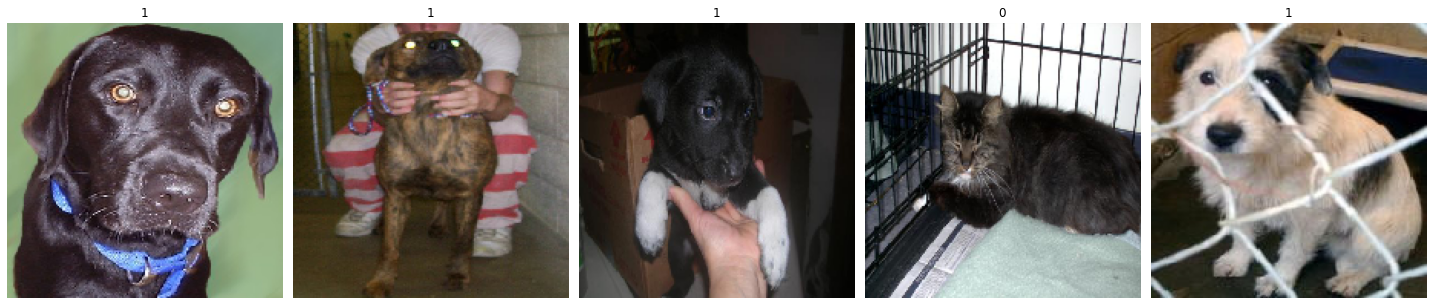

In [95]:
plotImages(sample_training_images[:5], sample_train_labels[:5])

In [98]:
# images are tensors of shape 180 x 180 x 3 (width, height, num channels)
sample_train_images.shape

(128, 180, 180, 3)

The above images and outputs give us a sense of the data, including samples belonging to different classes. 

### Flatten the data
While it's possible to flatten our image data before feeding it to the model, it's common to use the `keras.layer.Flatten()` class to efficiently flatten the input image inside of the `keras.Sequential` class--where we define the model. 

In [99]:
model = keras.Sequential([
                          keras.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
                          keras.layers.Flatten(), 
                          keras.layers.Dense(10)
                        ])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 97200)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                972010    
Total params: 972,010
Trainable params: 972,010
Non-trainable params: 0
_________________________________________________________________


We see that flattening a $180 \times 180 \times 3$ image tensor results in a large $97200 \times 1$ tensor.

# Summary
Concepts covered in this lesson:
- Loading *external data* into Colab.
- Building *data input pipelines* via the `tf.keras.preprocessing.image.ImageDataGenerator` class to efficiently work with data on disk to prepare it for the model. 
- *Flattening* input data using `tf.keras.Flatten` inside the `keras.Sequential` class. 
  